In [2]:
import pandas as pd

In [3]:
weather = pd.read_csv("../data/climat/weather.csv")  # weather data, Reykjavik
pool = pd.read_csv(
    "../data/heimsoknir_i_sundlaugar_heild.csv"
)  # pool visitors, Capital area

# rename columns
pool = pool.rename(
    columns={
        "dagsetning": "date",
        "timi_dags": "time_of_day",
        "sundlaug": "pool",
        "fjoldi_gesta": "visitors",
        "ar": "year",
        "manudur": "month",
        "vikudagur": "weekday",
        "arstid": "season",
        "helgi": "weekend",
    }
)


weather.head()

,average_temperature,max_temperature,min_temperature,rainfall,rain_type,snow_depth,snow_type,sunshine_hours,average_wind_speed,max_wind_speed,gusts,date
0,-0.2,2.4,-7.2,0.1,sn,0,2,0.0,5.1,10.4,16.6,2019-01-01
1,7.7,8.2,1.5,1.1,sl,0,0,0.0,7.8,11.6,19.0,2019-01-02
2,8.0,9.9,6.1,11.9,ri,0,0,0.0,8.0,14.0,22.8,2019-01-03
3,8.8,9.6,5.7,0.8,ri,0,0,0.0,8.3,11.4,18.1,2019-01-04
4,4.0,9.0,0.7,6.1,ri,0,0,0.2,6.1,9.0,15.0,2019-01-05


In [4]:
# add column "date time"
time_span = pool["time_of_day"]  # e.g. 12-13
time_of_day = time_span.map(lambda x: x.split("-")[1])  # e.g. 13
time_of_day = time_of_day.map(
    lambda x: x + ":00" if len(x) == 2 else "0" + x + ":00"
)  # e.g. 13:00
time_of_day = time_of_day.map(
    lambda x: "00:00" if x == "24:00" else x
)  # 24:00 -> 00:00

date = pool["date"]  # e.g. 2019-01-02
date = date.map(lambda x: x.split("-"))  # e.g. ['2019', '01', '02']
date = date.map(lambda x: x[2] + "-" + x[1] + "-" + x[0])  # e.g. 02-01-2019

pool["date_time"] = date + " " + time_of_day
pool["date_time"] = pd.to_datetime(pool["date_time"], format="%d-%m-%Y %H:%M")

pool["unix_time"] = pool["date_time"].map(lambda x: x.timestamp())

pool["weekend"] = pool["date_time"].map(lambda x: x.weekday() >= 5).astype(bool)
pool["weekday"] = pool["date_time"].map(lambda x: x.weekday()).astype(int)
pool["month"] = pool["date_time"].map(lambda x: x.month).astype(int)
pool["year"] = pool["date_time"].map(lambda x: x.year).astype(int)
pool["season"] = pool["date_time"].map(
    lambda x: x.month % 12 // 3 + 1
)  # 1: winter, 2: spring, 3: summer, 4: fall

pool["hour"] = pool["date_time"].map(lambda x: x.hour).astype(int)

pool = pool.drop(columns=["date", "time_of_day"])

pool

,pool,visitors,year,season,month,weekday,weekend,date_time,unix_time,hour
0,Grafarvogslaug,6,2019,3,8,0,False,2019-08-26 20:00:00,1.566850e+09,20
1,Grafarvogslaug,1,2019,3,8,0,False,2019-08-26 21:00:00,1.566853e+09,21
2,Árbæjarlaug,10,2019,3,8,1,False,2019-08-27 09:00:00,1.566896e+09,9
3,Árbæjarlaug,34,2019,3,8,1,False,2019-08-27 10:00:00,1.566900e+09,10
4,Árbæjarlaug,21,2019,3,8,1,False,2019-08-27 11:00:00,1.566904e+09,11
...,...,...,...,...,...,...,...,...,...,...
131389,Sundhöll Reykjavíkur,109,2023,3,6,0,False,2023-06-12 18:00:00,1.686593e+09,18
131390,Sundhöll Reykjavíkur,75,2023,3,6,0,False,2023-06-12 19:00:00,1.686596e+09,19
131391,Sundhöll Reykjavíkur,106,2023,3,6,0,False,2023-06-12 20:00:00,1.686600e+09,20
131392,Sundhöll Reykjavíkur,141,2023,3,6,0,False,2023-06-12 21:00:00,1.686604e+09,21


In [5]:
pool_sorted = pool.sort_values('date_time')
weather_sorted = weather.sort_values('date')

pool_sorted['date_time'] = pd.to_datetime(pool_sorted['date_time'])
weather_sorted['date'] = pd.to_datetime(weather_sorted['date'])

merged_data = pd.merge_asof(pool_sorted, weather_sorted, left_on='date_time', right_on='date', direction='forward')
merged_data = merged_data.ffill()

pool = merged_data.drop(columns=['date'])
pool.head()


,pool,visitors,year,season,month,weekday,weekend,date_time,unix_time,hour,...,max_temperature,min_temperature,rainfall,rain_type,snow_depth,snow_type,sunshine_hours,average_wind_speed,max_wind_speed,gusts
0,Grafarvogslaug,6,2019,3,8,0,False,2019-08-26 20:00:00,1.566850e+09,20,...,12.9,9.4,8.9,ri,0.0,0.0,1.1,3.6,6.7,12.2
1,Grafarvogslaug,1,2019,3,8,0,False,2019-08-26 21:00:00,1.566853e+09,21,...,12.9,9.4,8.9,ri,0.0,0.0,1.1,3.6,6.7,12.2
2,Grafarvogslaug,1,2019,3,8,1,False,2019-08-27 07:00:00,1.566889e+09,7,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5
3,Grafarvogslaug,16,2019,3,8,1,False,2019-08-27 08:00:00,1.566893e+09,8,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5
4,Grafarvogslaug,13,2019,3,8,1,False,2019-08-27 09:00:00,1.566896e+09,9,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5


In [6]:
# Grafarvogslaug
grafarvogslaug = pool[pool["pool"] == "Grafarvogslaug"]

# Árbæjarlaug
arbaejarlaug = pool[pool["pool"] == "Árbæjarlaug"]

# Breiðholtslaug
breidholtslaug = pool[pool["pool"] == "Breiðholtslaug"]

# Sundhöll Reykjavíkur
sundholl_reykjavikur = pool[pool["pool"] == "Sundhöll Reykjavíkur"]

# Vesturbæjarlaug
vesturbaejarlaug = pool[pool["pool"] == "Vesturbæjarlaug"]

# Laugardalslaug
laugardalslaug = pool[pool["pool"] == "Laugardalslaug"]

In [7]:
grafarvogslaug.head()

,pool,visitors,year,season,month,weekday,weekend,date_time,unix_time,hour,...,max_temperature,min_temperature,rainfall,rain_type,snow_depth,snow_type,sunshine_hours,average_wind_speed,max_wind_speed,gusts
0,Grafarvogslaug,6,2019,3,8,0,False,2019-08-26 20:00:00,1.566850e+09,20,...,12.9,9.4,8.9,ri,0.0,0.0,1.1,3.6,6.7,12.2
1,Grafarvogslaug,1,2019,3,8,0,False,2019-08-26 21:00:00,1.566853e+09,21,...,12.9,9.4,8.9,ri,0.0,0.0,1.1,3.6,6.7,12.2
2,Grafarvogslaug,1,2019,3,8,1,False,2019-08-27 07:00:00,1.566889e+09,7,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5
3,Grafarvogslaug,16,2019,3,8,1,False,2019-08-27 08:00:00,1.566893e+09,8,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5
4,Grafarvogslaug,13,2019,3,8,1,False,2019-08-27 09:00:00,1.566896e+09,9,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5


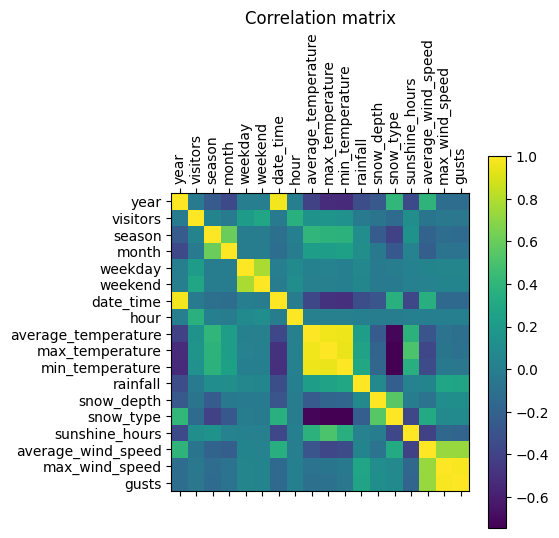

visitors               1.000000
hour                   0.363596
weekend                0.290324
weekday                0.213571
max_temperature        0.157075
average_temperature    0.146555
min_temperature        0.136995
sunshine_hours         0.115148
season                 0.045090
rainfall              -0.018452
year                  -0.022661
month                 -0.030921
date_time             -0.031823
max_wind_speed        -0.047706
gusts                 -0.055279
average_wind_speed    -0.070098
snow_depth            -0.072477
snow_type             -0.132244
Name: visitors, dtype: float64

In [8]:
# correlation matrix
import matplotlib.pyplot as plt

# grafarvogslaug
_grafarvogslaug = grafarvogslaug[
    [
        "year",
        "visitors",
        "season",
        "month",
        "weekday",
        "weekend",
        "date_time",
        "hour",
        "average_temperature",
        "max_temperature",
        "min_temperature",
        "rainfall",
        "snow_depth",
        "snow_type",
        "sunshine_hours",
        "average_wind_speed",
        "max_wind_speed",
        "gusts",
    ]
]

# set everything to numeric
_grafarvogslaug = _grafarvogslaug.apply(pd.to_numeric, errors="coerce")

grafarvogslaug_corr = _grafarvogslaug.corr()


# Plot correlation matrix
plt.matshow(grafarvogslaug_corr)
plt.colorbar()
# Add labels to the plot
plt.xticks(
    range(len(grafarvogslaug_corr.columns)),
    grafarvogslaug_corr.columns,
    rotation="vertical",
)
plt.yticks(range(len(grafarvogslaug_corr.columns)), grafarvogslaug_corr.columns)
plt.title("Correlation matrix")
plt.show()

grafarvogslaug_corr["visitors"].sort_values(ascending=False)

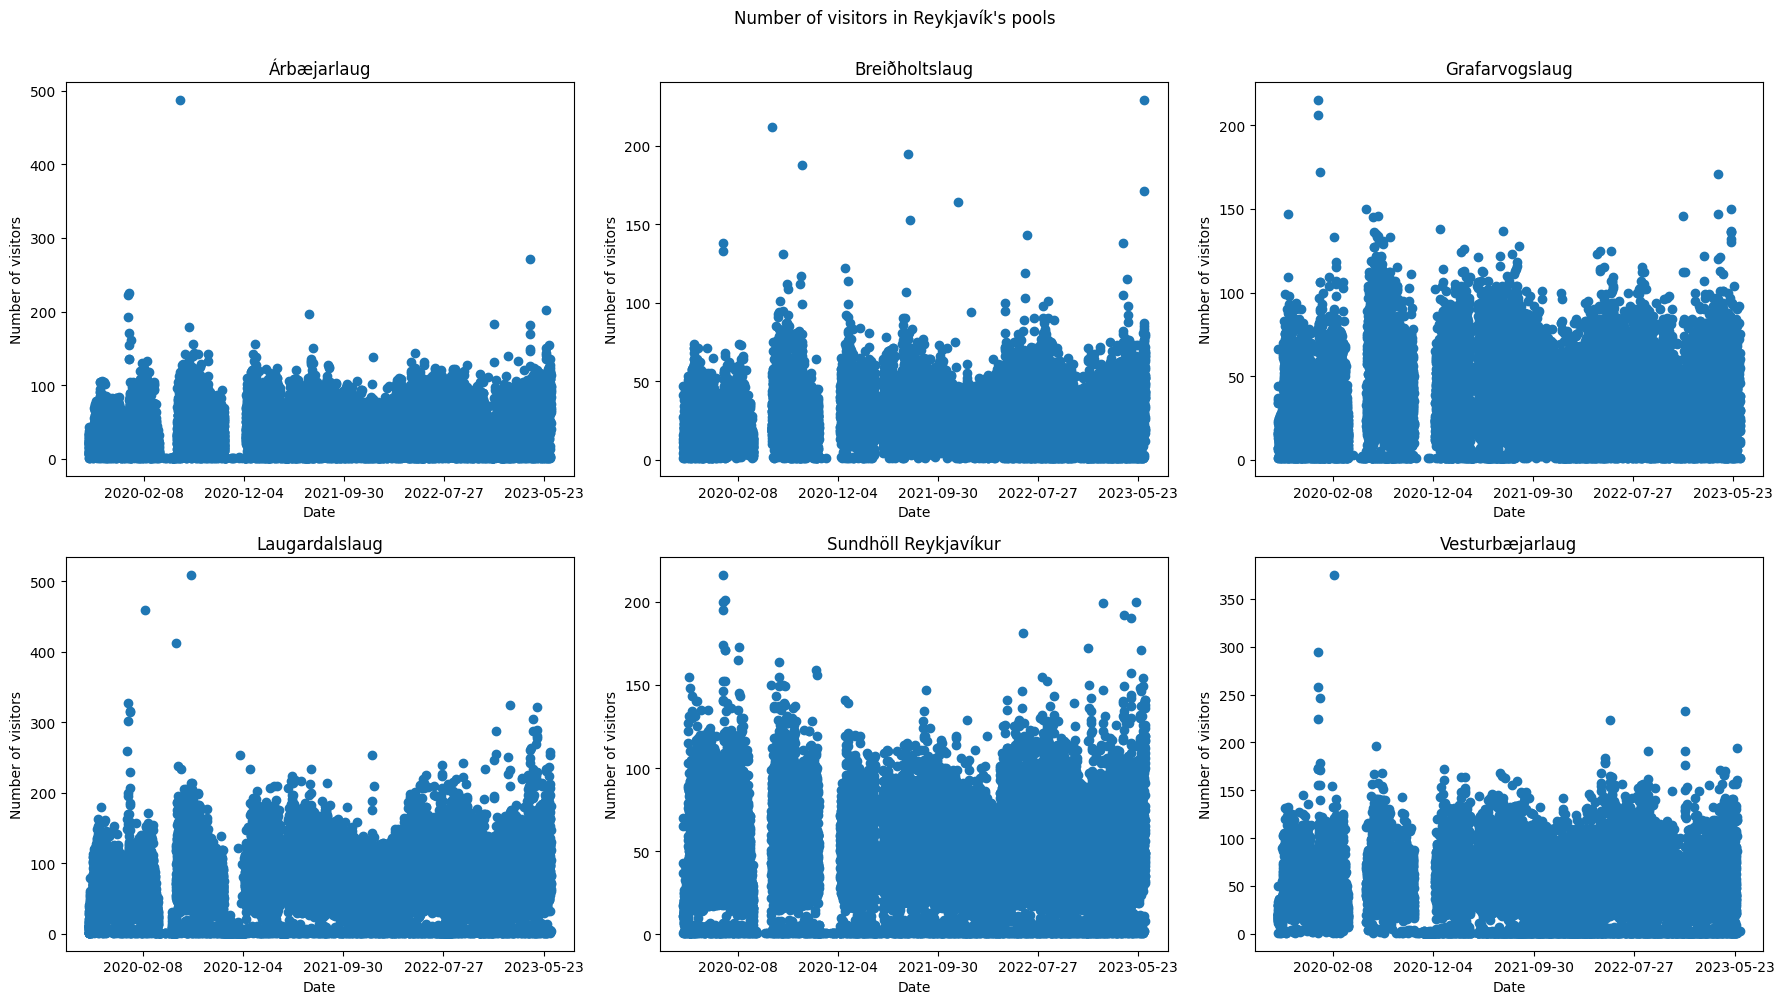

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
maxn = MaxNLocator(nbins=6)

axs[0, 0].scatter(arbaejarlaug["date_time"], arbaejarlaug["visitors"])
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Number of visitors")
axs[0, 0].set_title("Árbæjarlaug")
axs[0, 0].xaxis.set_major_locator(maxn)

axs[0, 1].scatter(breidholtslaug["date_time"], breidholtslaug["visitors"])
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Number of visitors")
axs[0, 1].set_title("Breiðholtslaug")
axs[0, 1].xaxis.set_major_locator(maxn)

axs[0, 2].scatter(grafarvogslaug["date_time"], grafarvogslaug["visitors"])
axs[0, 2].set_xlabel("Date")
axs[0, 2].set_ylabel("Number of visitors")
axs[0, 2].set_title("Grafarvogslaug")
axs[0, 2].xaxis.set_major_locator(maxn)

axs[1, 0].scatter(laugardalslaug["date_time"], laugardalslaug["visitors"])
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Number of visitors")
axs[1, 0].set_title("Laugardalslaug")
axs[1, 0].xaxis.set_major_locator(maxn)

axs[1, 1].scatter(sundholl_reykjavikur["date_time"], sundholl_reykjavikur["visitors"])
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Number of visitors")
axs[1, 1].set_title("Sundhöll Reykjavíkur")
axs[1, 1].xaxis.set_major_locator(maxn)

axs[1, 2].scatter(vesturbaejarlaug["date_time"], vesturbaejarlaug["visitors"])
axs[1, 2].set_xlabel("Date")
axs[1, 2].set_ylabel("Number of visitors")
axs[1, 2].set_title("Vesturbæjarlaug")
axs[1, 2].xaxis.set_major_locator(maxn)

fig.suptitle("Number of visitors in Reykjavík's pools", y=1)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

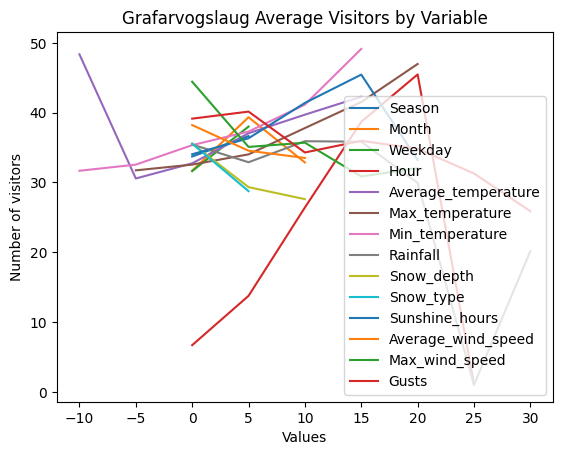

In [10]:
import matplotlib.pyplot as plt

variables = [
    # "year",
        "season",
        "month",
        "weekday",
        "hour",
        "average_temperature",
        "max_temperature",
        "min_temperature",
        "rainfall",
        "snow_depth",
        "snow_type",
        "sunshine_hours",
        "average_wind_speed",
        "max_wind_speed",
        "gusts",]  # List of variables to consider

cleaned_data = grafarvogslaug.dropna(subset=variables)

rounding_factor = 5
data_dict = {}

for var in variables:
    rounded_var = cleaned_data[var].map(lambda x: round(x / rounding_factor) * rounding_factor)
    avg_visitors = cleaned_data.groupby(rounded_var)['visitors'].mean()
    data_dict[var] = avg_visitors

# Plotting
for var in variables:
    x_values = data_dict[var].index
    y_values = data_dict[var].values

    plt.plot(x_values, y_values, label=var.capitalize())

plt.xlabel('Values')
plt.ylabel('Number of visitors')
plt.title('Grafarvogslaug Average Visitors by Variable')
plt.legend()
plt.show()


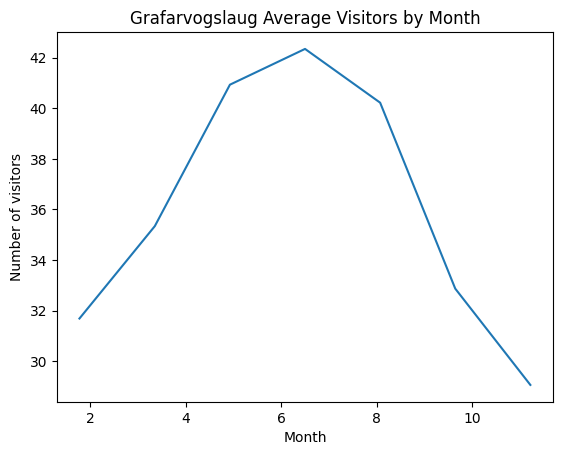

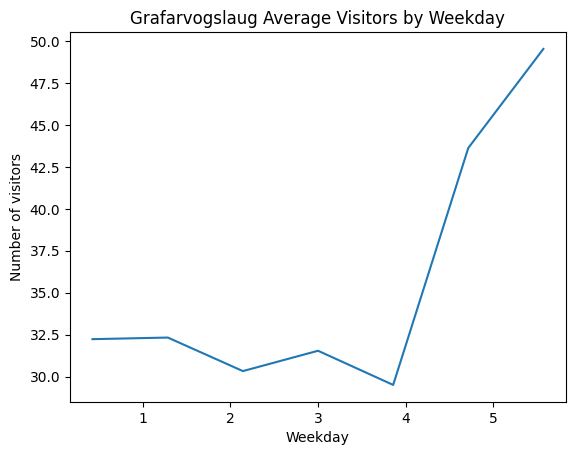

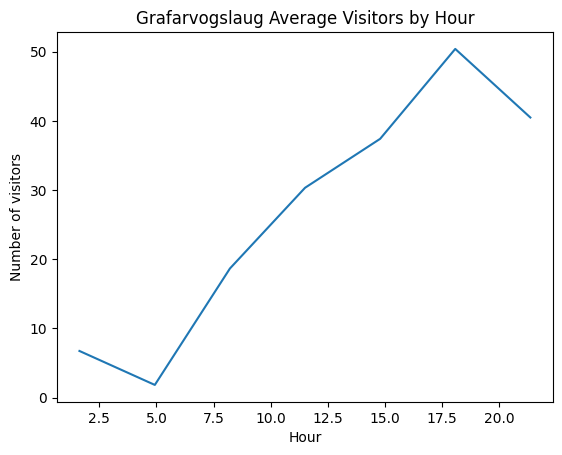

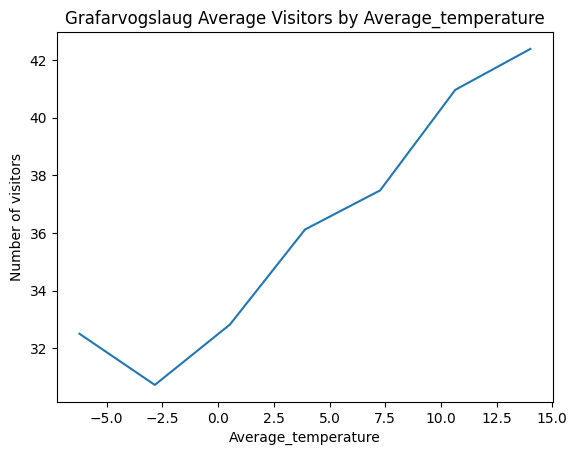

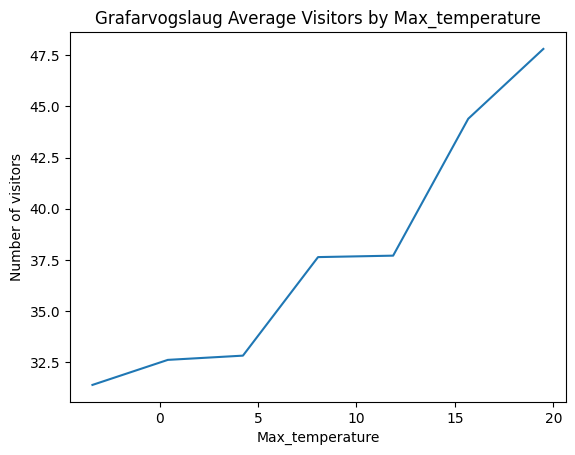

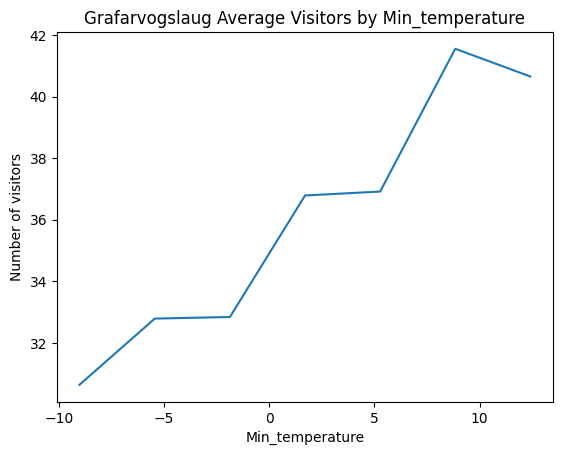

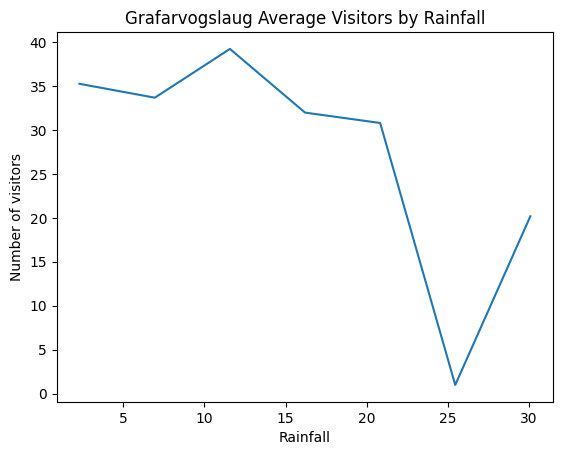

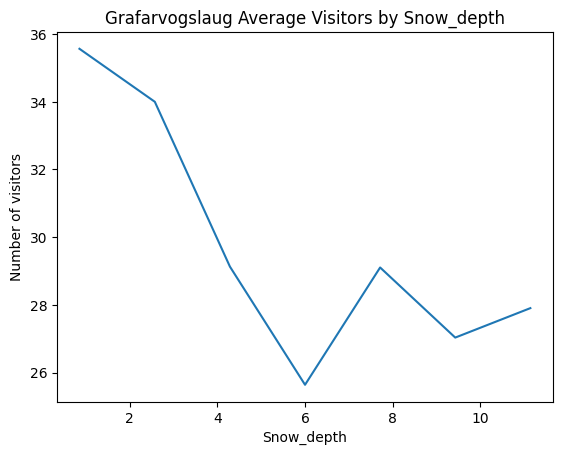

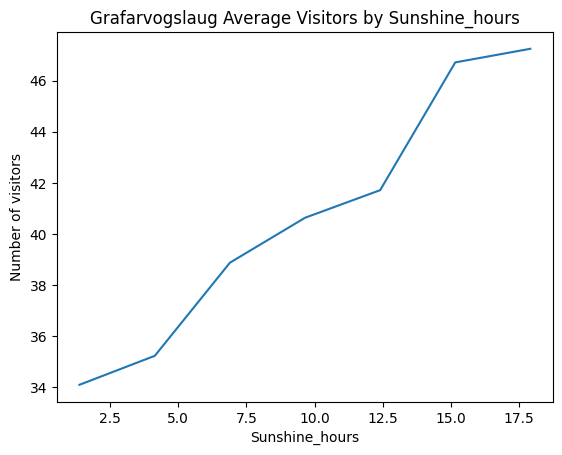

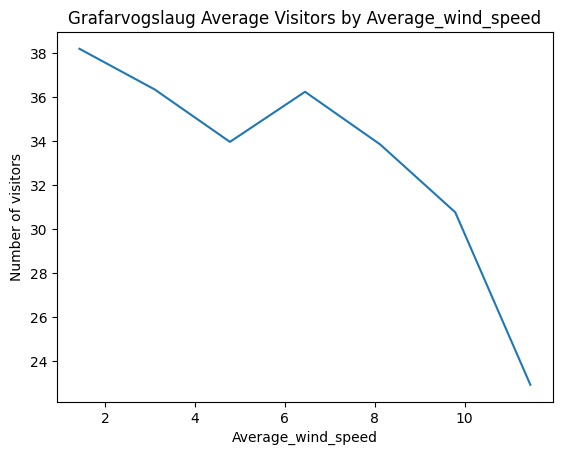

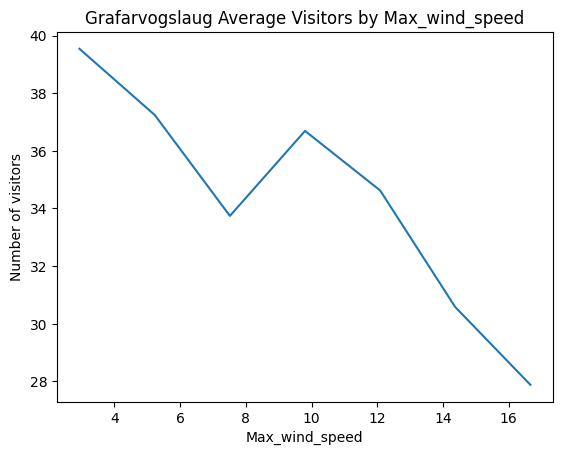

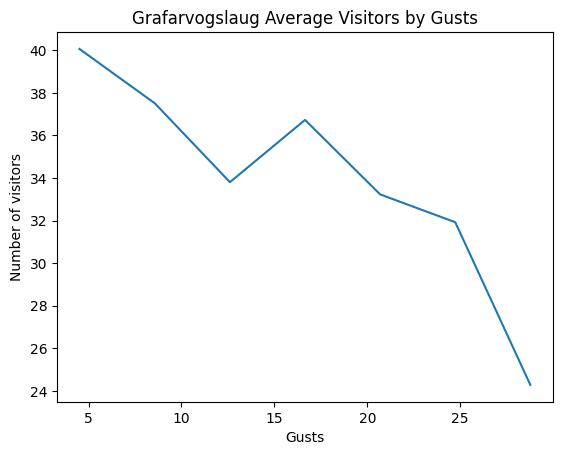

In [29]:
import matplotlib.pyplot as plt

variables = variables = [
    # "year",
        "month",
        "weekday",
        "hour",
        "average_temperature",
        "max_temperature",
        "min_temperature",
        "rainfall",
        "snow_depth",
        "sunshine_hours",
        "average_wind_speed",
        "max_wind_speed",
        "gusts",] 

cleaned_data = grafarvogslaug.dropna(subset=variables)

# bin averaging accross variables
num_bins = 7
data_dict = {}

for var in variables:
    binned_var = pd.cut(cleaned_data[var], num_bins)

    avg_visitors = cleaned_data.groupby(binned_var)['visitors'].mean()
    data_dict[var] = avg_visitors

# Create dataframe
df = pd.DataFrame(data_dict)
df['visitors'] = cleaned_data['visitors']

# Create separate plots for each variable
for var in variables:
    x_values = data_dict[var].index.map(lambda x: x.mid) # get bin midpoints
    y_values = data_dict[var].values

    plt.figure()
    plt.plot(x_values, y_values, label=var.capitalize())
    

    plt.xlabel(var.capitalize())
    plt.ylabel('Number of visitors')
    plt.title(f'Grafarvogslaug Average Visitors by {var.capitalize()}')

plt.show()


In [42]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [43]:
from sklearn.linear_model import LinearRegression

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(train_df[variables], train_df['visitors'])


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

pretrain_data = pd.concat(
    [
        grafarvogslaug,
        arbaejarlaug,
        breidholtslaug,
        sundholl_reykjavikur,
        vesturbaejarlaug,
    ]
)

finetune_data = laugardalslaug.copy()

combined_data = pd.concat([pretrain_data, finetune_data], ignore_index=True)

# one-hot encoding
# one_hot = pd.get_dummies(combined_data['pool'], prefix='pool')

# X = pd.concat([one_hot, combined_data[['weekday', 'weekend', 'hour']]], axis=1)
X = combined_data[["weekday", "weekend", "hour"]]
y = np.log(combined_data["visitors"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
# from sklearn.svm import SVR
import xgboost as xgb

# pretrained_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=2000, max_depth=3, learning_rate=0.1, random_state=42)
pretrained_model = xgb.XGBRegressor()

pretrained_model.fit(X_train, y_train)

score = pretrained_model.score(X_train, y_train)
print("Pretraining score:", score)

Pretraining score: 0.5417109476715316


In [11]:
# load the model's where we left off
finetune_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=2000,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
)

params = pretrained_model.get_xgb_params()
finetune_model.set_params(**params)

X_finetune = finetune_data[["weekday", "weekend", "hour"]]
y_finetune = np.log(finetune_data["visitors"])

X_finetune_train, X_finetune_test, y_finetune_train, y_finetune_test = train_test_split(
    X_finetune, y_finetune, test_size=0.2, random_state=42
)

finetune_model.fit(X_train, y_train)

score = finetune_model.score(X_train, y_train)
print("Finetuning score:", score)

Finetuning score: 0.541682838094101


In [12]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = finetune_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 0.4476910864366218
R-squared Score: 0.5479235467278334


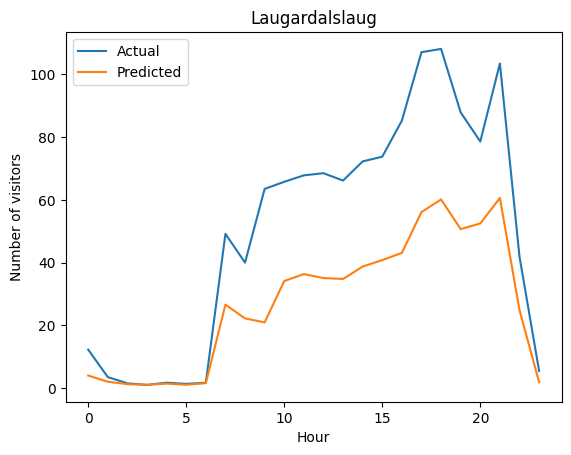

In [13]:
pred = finetune_model.predict(X_finetune_test)
actual = y_finetune_test
input = X_finetune_test

pred = np.exp(pred)
actual = np.exp(actual)

df = pd.DataFrame({"input": input["hour"], "actual": actual, "pred": pred})
df = df.sort_values(by=["input"])
df = df.reset_index(drop=True)
df = df.groupby("input").mean()
df = df.reset_index()

import matplotlib.pyplot as plt

plt.plot(df["actual"], label="Actual")
plt.plot(df["pred"], label="Predicted")
plt.xlabel("Hour")
plt.ylabel("Number of visitors")
plt.title("Laugardalslaug")
plt.legend()
plt.show()

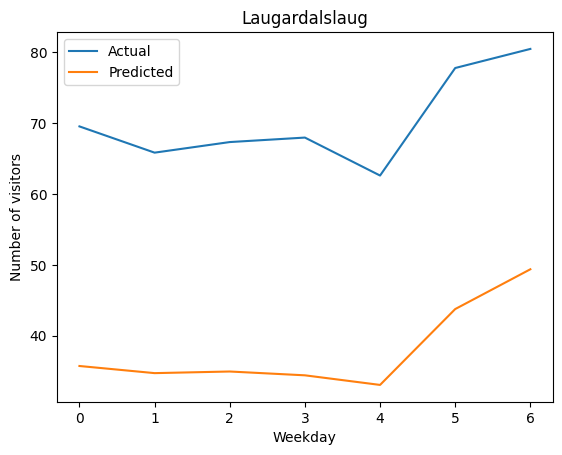

In [14]:
pred = finetune_model.predict(X_finetune_test)
actual = y_finetune_test
input = X_finetune_test

pred = np.exp(pred)
actual = np.exp(actual)

df = pd.DataFrame({"input": input["weekday"], "actual": actual, "pred": pred})
df = df.sort_values(by=["input"])
df = df.reset_index(drop=True)
df = df.groupby("input").mean()
df = df.reset_index()

import matplotlib.pyplot as plt

plt.plot(df["actual"], label="Actual")
plt.plot(df["pred"], label="Predicted")
plt.xlabel("Weekday")
plt.ylabel("Number of visitors")
plt.title("Laugardalslaug")
plt.legend()
plt.show()

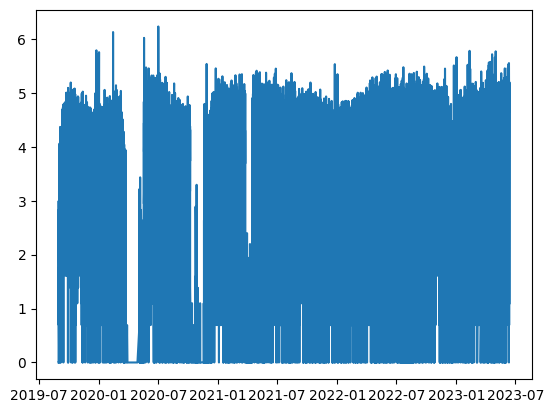

In [15]:
from matplotlib import pyplot as plt
import numpy as np

date = laugardalslaug["date_time"]
visitors = laugardalslaug["visitors"]

visitors = np.log(visitors)

plt.plot(date, visitors)

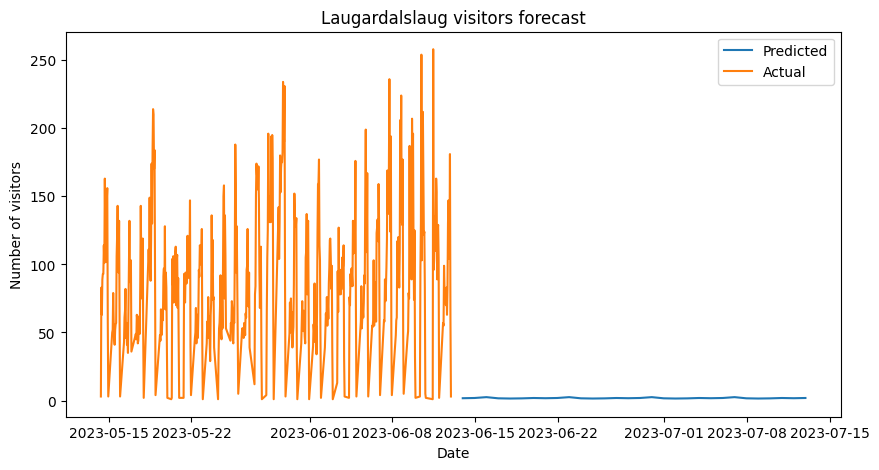

In [16]:
# forecast next 30 days
import datetime
import numpy as np

# get last date
last_date = laugardalslaug["date_time"].iloc[-1]

# create next 30 days
next_30_days = []
for i in range(1, 31):
    next_30_days.append(last_date + datetime.timedelta(days=i))

# create dataframe
next_30_days = pd.DataFrame(next_30_days, columns=["date_time"])

# add weekday, weekend and hour
next_30_days["weekday"] = next_30_days["date_time"].dt.weekday
next_30_days["weekend"] = next_30_days["weekday"].apply(lambda x: 1 if x > 4 else 0)
next_30_days["hour"] = next_30_days["date_time"].dt.hour

# make predictions
next_30_days["visitors"] = finetune_model.predict(
    next_30_days[["weekday", "weekend", "hour"]]
)
next_30_days["visitors"] = np.exp(
    next_30_days["visitors"]
)  # convert back to original scale
# next_30_days['visitors'] = next_30_days['visitors'].apply(lambda x: 0 if x < 0 else x)
# next_30_days['visitors'] = next_30_days['visitors'].apply(lambda x: np.round(x))

# Get the actual visitors data for the previous 30 days
actual_data = laugardalslaug[
    laugardalslaug["date_time"] >= (last_date - datetime.timedelta(days=30))
]

# Plot predictions and actual data
plt.figure(figsize=(10, 5))
plt.plot(next_30_days["date_time"], next_30_days["visitors"], label="Predicted")
plt.plot(actual_data["date_time"], actual_data["visitors"], label="Actual")
plt.title("Laugardalslaug visitors forecast")
plt.xlabel("Date")
plt.ylabel("Number of visitors")
plt.legend()
plt.show()